In [1]:
import numpy as np
import pandas as pd
import os

### 1. Load BLS raw data

In [2]:
# add NAICS 31-33
years = ['1990', '2000', '2010', '2020']
files = []

for year in years:
    folder = sorted(os.listdir('../BLS_raw/' + year + '.annual.by_industry'))
    for file in folder:
        if '31-33 ' in file[12:18]:
            files.append(file)
        else:
            pass
files

['1990.annual 31-33 Manufacturing.csv',
 '2000.annual 31-33 Manufacturing.csv',
 '2010.annual 31-33 Manufacturing.csv',
 '2020.annual 31-33 NAICS 31-33 Manufacturing.csv']

In [3]:
df_list = []
 
# loop through year and file to append dataframes into a list
for year in years:
    for file in files:
        if year in file:
            temp_df = pd.read_csv('../BLS_raw/' + year + '.annual.by_industry/' + file)
            mask_non50 = ((temp_df['area_fips'].str[-3:] == '000') | 
                          (temp_df['area_fips'].str[:1] == 'C') | 
                          (temp_df['area_fips'].str[:2] == 'US') | 
                          (temp_df['area_fips'].str[:1] == '7'))
            temp_df = temp_df[~mask_non50] # apply Kurt's filter within loop
            df_list.append(temp_df)
        else:
            pass

# store dataframes in dictionary
names = []
for x in range(0, len(files)):
    names.append('df' + files[x][12:14]+ '_' + files[x][:4])

d = dict(zip(names, df_list))
d.keys()

dict_keys(['df31_1990', 'df31_2000', 'df31_2010', 'df31_2020'])

### 2. Process raw data

In [4]:
# drop undefined counties
for key in d.keys():
    d[key] = d[key][d[key]['area_fips'].str[-3:] != '999']
    print(d[key].shape)

(2623, 43)
(2659, 43)
(3184, 43)
(3180, 43)


In [5]:
# merge public and private sector employment within-county
for key in d.keys():
    d[key] = (d[key].groupby(by=['area_fips', 'area_title'], as_index=False)['annual_avg_emplvl'].sum())
    print(d[key].shape)

(2605, 3)
(2635, 3)
(3090, 3)
(3092, 3)


In [6]:
# load typology (US Census geographical classifications) and regional data
typ = pd.read_csv('typology/typology.csv')

# change county codes to proper fips
typ['fips'] = typ['fips'].astype(str).str.zfill(5)

# merge BLS data with delineations and regions
for key in d.keys():
    d[key] = d[key].merge(typ, how='right', left_on='area_fips', right_on='fips')

# export selected columns
final_cols = ['fips', 'name', 'State', 'State Code', 'Region', 'Division',
              'Region_alt', 'msa', 'type_bea20', 'annual_avg_emplvl']

for key in d.keys():
    d[key][final_cols].to_csv('my_naics/naics_' + key[2:] + '.csv', index_label=False)

### 3. Calculate employment change columns

In [8]:
# load new NAICS CSVs
path = 'my_naics/naics_'
code = '31'

# use big loop to update all previously processed NAICS files

df90 = pd.read_csv(path + code + '_1990.csv')
df00 = pd.read_csv(path + code + '_2000.csv')
df10 = pd.read_csv(path + code + '_2010.csv')
df20 = pd.read_csv(path + code + '_2020.csv')
    
# merge years under NAICS code
temp1 = df90.merge(df00, how='inner', left_on='fips', right_on='fips', suffixes=['_90', '_00'])
temp2 = df10.merge(df20, how='inner', left_on='fips', right_on='fips', suffixes=['_10', '_20'])
df = temp1.merge(temp2, how='inner', left_on='fips', right_on='fips')
    
# clean column names
cols = df.columns.tolist()[:10]
for col in df.columns.tolist()[10:]:
    if col[:-3] == 'annual_avg_emplvl':
        cols.append(col)
    else:
        pass
df = df[cols]
df.columns = df.columns.str.replace('_90', '')
df = df.rename(columns={'annual_avg_emplvl': 'annual_avg_emplvl_90'})
    
# replace nulls with zeroes 
empl_cols = df.columns[-4:]
df[empl_cols] = df[empl_cols].fillna(0)

# rate of change function
def rate_chg(df, year1, year2, chg):
    df[chg] = np.where((df[year1]== 0),
                      ((df[year2] - df[year1]) / 1).round(4),
                      ((df[year2] - df[year1]) / df[year1]).round(4))
    
# define new column namer
namer = empl_cols.str.split('_')

# calculate rate of change
for x in range(0,3):
    rate_chg(df, empl_cols[x], empl_cols[x+1], 'chg_' + namer[x][2] + '_' + namer[x][3] + '_' + namer[x+1][3])
    
# calculate total rate of change column (1990-2020)
df['chg_emplvl_90_20'] = np.where((df['annual_avg_emplvl_90']==0),
                                 ((df['annual_avg_emplvl_20'] - df['annual_avg_emplvl_90']) / 1).round(4),
                                 ((df['annual_avg_emplvl_20'] - df['annual_avg_emplvl_90']) / df['annual_avg_emplvl_90']).round(4))
    
# export file
print(code, df.shape)
df.to_csv('my_naics_chg/naics_' + code + '.csv', index_label=False)

31 (3143, 17)


### 4. Incorporate spatial data

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# load US counties SHP
gdf_full = gpd.read_file('../GIS Data/usa_census_counties_2018_20m/')
gdf_full.set_index('GEOID', inplace=True)

# drop non-continental columns (AK, HI, & PR)
mask_non_continental = ((gdf_full['STATEFP'] == '02') | (gdf_full['STATEFP'] == '15') | (gdf_full['STATEFP'] == '72'))
gdf_continental = gdf_full[~mask_non_continental]

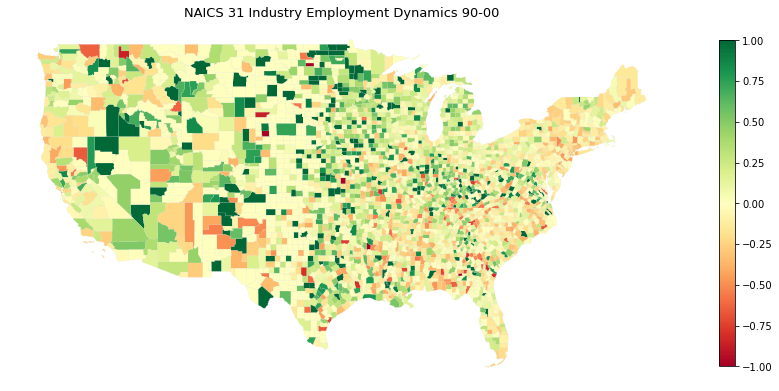

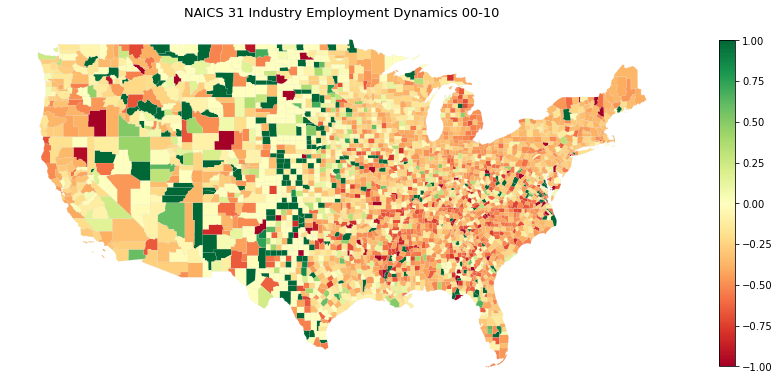

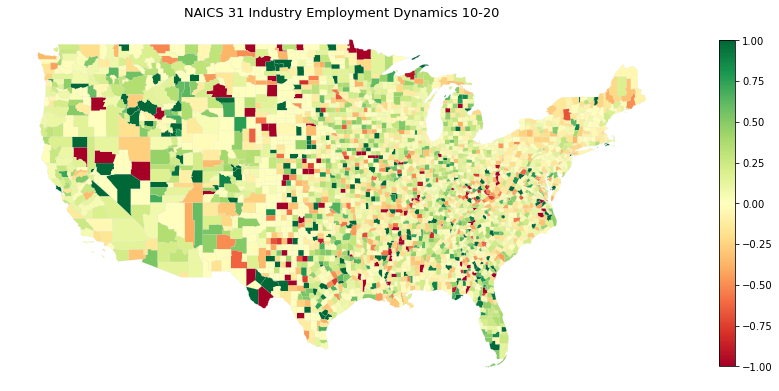

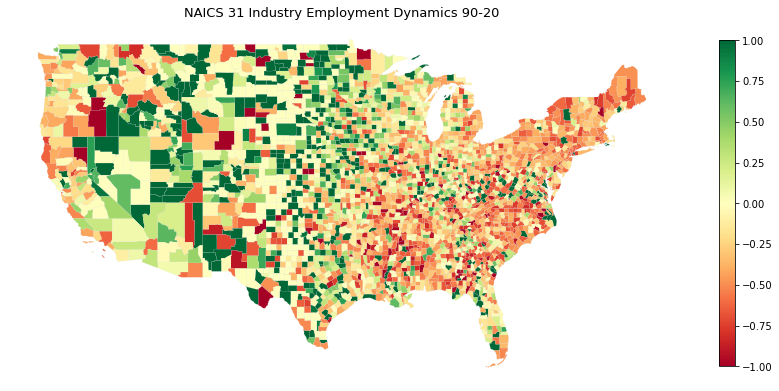

In [21]:
# load NAICS files with change columns
code = '31'
path = 'my_naics_chg/naics_'

df = pd.read_csv(path + code + '.csv')
df['fips'] = df['fips'].astype(str).str.zfill(5)
df = df.set_index('fips')
    
# merge with continental gdf
gdf = gdf_continental.merge(df, how='left', left_index=True, right_index=True)
    
# export to shapefile
# gdf.to_file('SHPs/NAICS', driver ='ESRI Shapefile')
    
# SPATIAL ANALYSIS
for col in gdf.columns[20:]:
    ax = gdf.plot(column=col, cmap='RdYlGn',
                  edgecolor='lightgrey', linewidth=0.1,
                  legend=True, legend_kwds={'shrink': 0.6},
                  vmax=1, vmin=-1,
                  figsize=(15,10),
                  missing_kwds={'color': 'white', 'hatch': 'XXX',
                                'edgecolor': 'lightgrey', 'linewidth' : 0.2,
                                'label': 'Null or No Data'})
    
    title = 'NAICS ' + code + ' Industry Employment Dynamics ' + col[11:13] + '-' + col[14:]
    ax.set_title(title, fontsize = 13)
    ax.axis("off")
    
    # save figure
    ax.get_figure().savefig('maps/' + title, dpi=600, bbox_inches="tight")

In [ ]:
# create separate code book for cluster analysis